## Importa librerie

In [20]:
import cv2
import numpy as np
from functools import reduce

from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size

## Costanti, variabili e impostazioni globali

In [21]:
MONTA_DRIVE = False
DEBUG = True
VERBOSE = True
IMAGE_PATH = 'data/duca.png'
N_CLUSTERS = 3

Le seguenti sono le costanti rielaborate e i settaggi globali

In [22]:
if DEBUG:
  DEBUG = DEBUG + VERBOSE

pylab.rcParams['figure.figsize'] = (14.0, 6.0) # this controls figure size in the notebook

## Collega Google Drive

In [23]:
if MONTA_DRIVE:
    from google.colab import drive

    drive.mount(r"/content/drive", force_remount=True)
    %cd /content/drive/.shortcut-targets-by-id/1yAn04eh371ZRb79GrK9PbepGcXi-FkGj/SIV Project
    !ls

# Versione efficiente

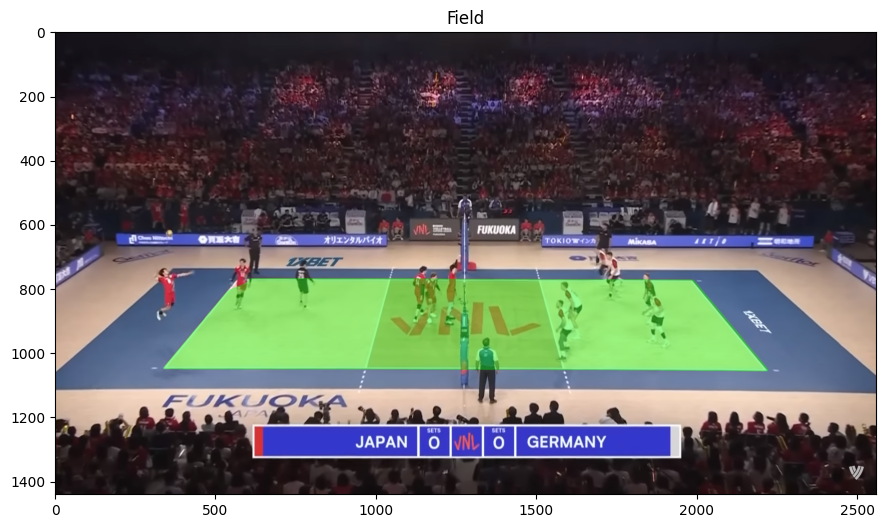

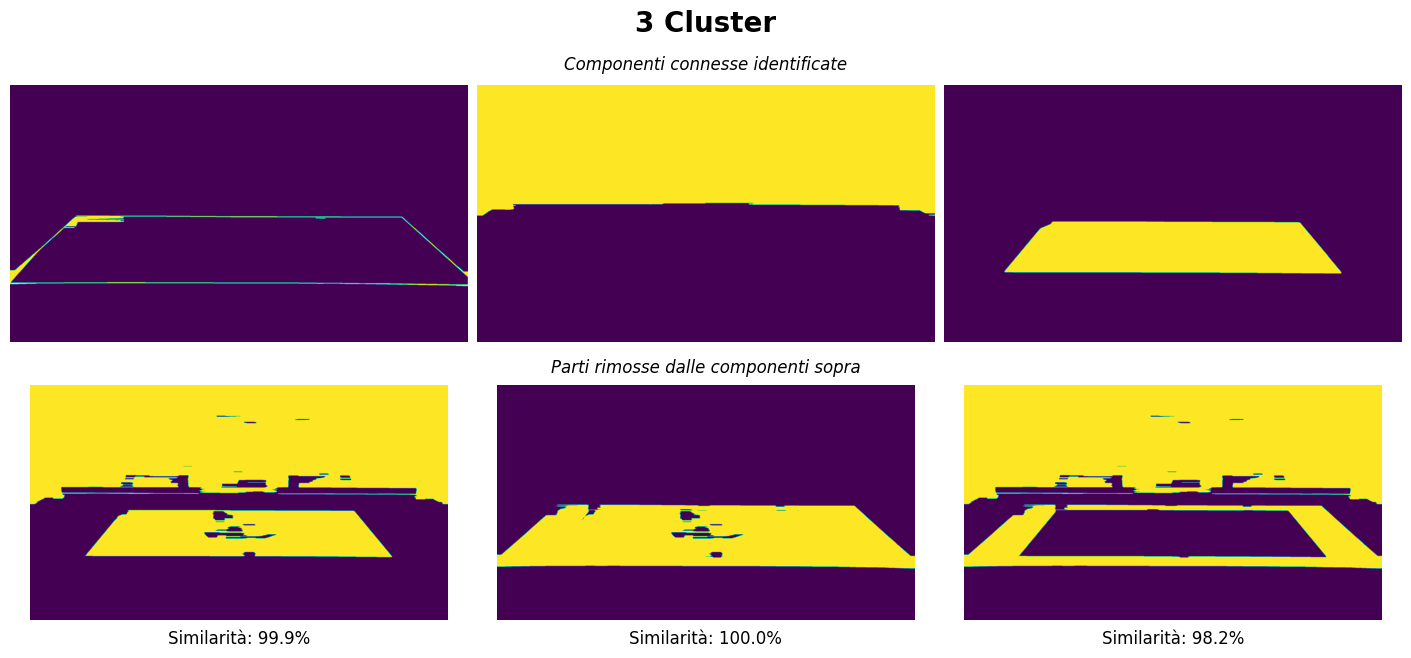

In [24]:
def kmeans_segmentation(image_rgb, K=N_CLUSTERS):
    pixels = image_rgb.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    _, labels, _ = cv2.kmeans(pixels, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return labels.reshape(image_rgb.shape[:2])

def remove_short_sequences_fast(mask, threshold):
    # Applica un filtro morfologico orizzontale per "ripulire" piccole sequenze
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (threshold, 1))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return closed

def extract_largest_component(mask):
    num_labels, labels_im = cv2.connectedComponents(mask)
    if num_labels <= 1:
        return np.zeros_like(mask)
    areas = np.bincount(labels_im.flatten())[1:]  # Skip background
    max_label = np.argmax(areas) + 1
    return (labels_im == max_label).astype(np.uint8) * 255

def apply_hough(image):
    # Line detection con Hough
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=10, minLineLength=5, maxLineGap=200)
    h, w = image.shape
    lines_img = np.zeros((h, w, 3), dtype=np.uint8)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lines_img, (x1, y1), (x2, y2), (255, 255, 255), 2)

    gray = cv2.cvtColor(lines_img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closed

def find_field(labels_map, K=N_CLUSTERS):
  W = image_rgb.shape[1]
  H = image_rgb.shape[0]
  CENTER = (W // 2, 2 * H // 3)

  min_distance = float('inf')
  final_mask = None
  filled_components = []
  components = []
  
  if DEBUG:
    fig, axs = plt.subplots(DEBUG, 1, constrained_layout=True, figsize=(14, 1 + 2.5 * DEBUG))
    fig.suptitle(f'{K} Cluster', fontweight='bold', size=20, y=1.07)
    
    figures.append(fig)
    
    if DEBUG < 2:
      axs = [axs]
    
    for ax in axs:
      ax.remove()
      
    # add subfigure per subplot
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]
    
    subfigs[0].suptitle('Componenti connesse identificate', fontstyle='italic')
    axs = subfigs[0].subplots(1, K)

  for i in range(K):
    # Crea maschera binaria per ogni cluster
    mask = ((labels_map == i).astype(np.uint8)) * 255

    # Denoising orizzontale
    blurred = cv2.GaussianBlur(mask, (151, 1), 0)
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    # Rimozione sequenze brevi
    cleaned = remove_short_sequences_fast(binary, threshold=50)

    # Prendi la componente connessa più grande
    component_mask = extract_largest_component(cleaned)
    components.append(component_mask)

    # Trova i contorni dell'immagine
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filled = fill_contours(component_mask, contours)
    filled_components.append(filled)

    if DEBUG:
      axs[i].imshow(filled)
      axs[i].axis('off')
  
  if DEBUG == 2: # Verbose  
    subfigs[1].suptitle('Parti rimosse dalle componenti sopra', fontstyle='italic')
    axs = subfigs[1].subplots(1, K)
  
  # D: [0, 255] => [False, True] 
  components = list( map(lambda x: x > 0, components) )
    
  # Scegliamo la componente connessa che 
  # a) non ha buchi in mezzo
  # b) è più vicina al centro dell'immagine
  for i in range(K):
    filled = filled_components[i]
    
    # Dobbiamo rimuovere dalla componente presa in analisi
    # le aree degli altri cluster, per poi assicurarci che non ci siano buchi
    
    # Applicheremo la seguente tabella della verità con le altre maschere
    # A and not B
    #   dove A è la componente connessa riempita e presa in analisi
    #   e B è una generica area di un altro cluster
    # nel nostro caso, le possibili B vengono unite (OR delle maschere) 
    # e rimosse tutte insieme da A
    
    other_masks = components.copy()
    del other_masks[i]
    # in questa maschera aggiungiamo tutto ciò che è presente negli altri cluster
    to_remove = reduce(lambda x, y: x | y, other_masks)

    # applichiamo la tabella A | not B e poi riconvertiamo nel dominio [0, 255]
    mask = ( filled & (~to_remove) ) * 255

    # 100% - whites_removed / total_whites (differences)      
    similarity =  1 - np.sum(filled > mask) / np.sum(filled > 0)
    
    if DEBUG == 2: # Verbose
      axs[i].imshow(to_remove)
      axs[i].axis('off')
      axs[i].text(0.5, -0.1, f'Similarità: {int(similarity * 1000) / 10}%',
        transform=axs[i].transAxes, ha='center', fontsize=12)
      
    if similarity > 0.9:
      # Calcola il centro di massa della maschera
      M = cv2.moments(filled)
      if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        # Calcola la distanza euclidea dal centro ideale
        distance = np.linalg.norm(np.array([cx, cy]) - np.array([CENTER[0], CENTER[1]]))
        if distance < min_distance:
          min_distance = distance
          final_mask = filled
    
  return final_mask

def fill_contours(mask, contours):
  contour_img = np.zeros_like(mask)
  cv2.drawContours(contour_img, contours, -1, 255, 1)

  h, w = contour_img.shape

  # Top and bottom borders
  for y in [0, h - 1]:
      row = contour_img[y, :]
      on_indices = np.where(row > 0)[0]
      if len(on_indices) >= 2:
          for i in range(len(on_indices) - 1):
              x1, x2 = on_indices[i], on_indices[i + 1]
              if x2 - x1 > 1:
                  cv2.line(contour_img, (x1, y), (x2, y), 255, 1)

  # Left and right borders
  for x in [0, w - 1]:
      col = contour_img[:, x]
      on_indices = np.where(col > 0)[0]
      if len(on_indices) >= 2:
          for i in range(len(on_indices) - 1):
              y1, y2 = on_indices[i], on_indices[i + 1]
              if y2 - y1 > 1:
                  cv2.line(contour_img, (x, y1), (x, y2), 255, 1)
  

  closed = apply_hough(contour_img)
  closed = apply_hough(closed)

  # Fill contours
  contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  filled = np.zeros_like(mask)
  cv2.drawContours(filled, contours, -1, 255, thickness=cv2.FILLED)
    
  return filled

# === MAIN EXECUTION ===
figures = []

image = cv2.imread(IMAGE_PATH)
original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Increase saturation (S channel)
h, s, v = cv2.split(hsv)
s = cv2.multiply(s, 2)  # Increase saturation by 50%
s = np.clip(s, 0, 255).astype(np.uint8)

# Merge back and convert to RGB
enhanced = cv2.merge([h, s, v])
image_rgb = cv2.cvtColor(enhanced, cv2.COLOR_HSV2RGB)

# apply K-means
labels_map = kmeans_segmentation(image_rgb)

final_mask = find_field(labels_map)

# green overlay
overlay = np.zeros_like(original_rgb, dtype=np.uint8)
overlay[:] = (0, 255, 0)  # Pure green

# Alpha blend
alpha = 0.4  # 0 = transparent, 1 = solid green
blended = cv2.addWeighted(original_rgb, 1 - alpha, overlay, alpha, 0)

output = np.where(final_mask[:, :, np.newaxis] == 255, blended, original_rgb)

res_fig, res_ax = plt.subplots(1, 1)
res_ax.imshow(output)
res_ax.set_title('Field')

figures.insert(0, res_fig)

for figure in figures:
  display(figure)
  plt.close(figure)

## Net Recognition

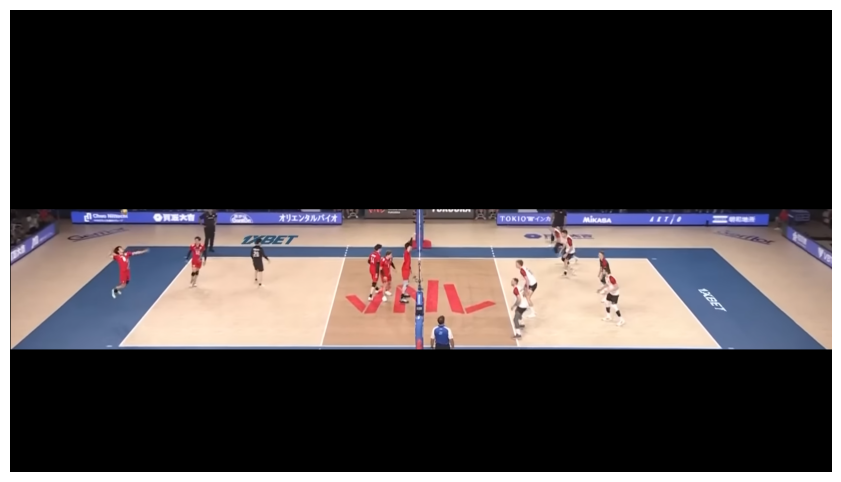

In [25]:
# Crea una nuova maschera vuota
extended_mask = np.zeros_like(final_mask)
# Trova i limiti verticali (y_min, y_max) della regione nella final_mask
ys, xs = np.where(final_mask > 0)
if len(ys) > 0:
    y_min = ys.min()
    y_max = ys.max()
    h_region = y_max - y_min + 1
    # Calcola la nuova y_min estesa verso l'alto di metà altezza
    new_y_min = max(0, int(y_min - h_region / 2))
    # Calcola l'altezza effettiva da copiare per evitare errori di broadcasting
    src_height = y_max - y_min + 1
    dst_height = final_mask.shape[0] - new_y_min
    copy_height = min(src_height, dst_height)
    # Copia la regione originale nella nuova posizione estesa
    extended_mask[new_y_min:y_min+copy_height, :] = 255
    # Aggiorna final_mask con la versione estesa

# Converti la maschera in un'immagine a colori
extended_mask = cv2.cvtColor(extended_mask, cv2.COLOR_GRAY2BGR)
# Applica la maschera all'immagine originale
masked_image = cv2.bitwise_and(original_rgb, extended_mask)
# Mostra l'immagine finale
plt.imshow(masked_image)
plt.axis('off')
plt.show()

[[1270  964]
 [1276  622]] 342.0526275297414


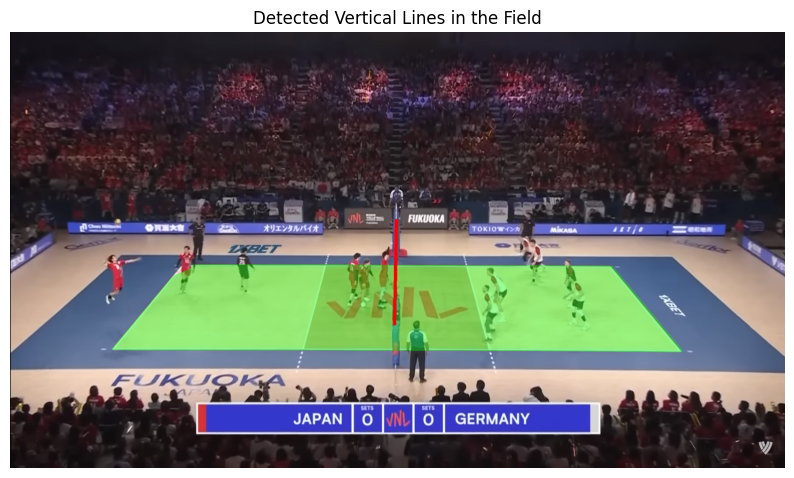

In [26]:
# Step 1: Preprocess the image
gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
edges = cv2.Canny(gray, 50, 150)  # Apply edge detection

# Step 2: Detect vertical lines using Hough Line Transform
# lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=1000)
all_lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=120, maxLineGap=1000)

# Create an empty image to draw the vertical lines
vertical_lines_img = np.zeros_like(edges)

# Step 8: Overlay the detected areas on the original masked image
overlay = output.copy() # Create a copy of the original masked image

lines = []
W = image_rgb.shape[1]
# Filter and draw vertical lines
if all_lines is not None:
    for line in all_lines:
        x1, y1, x2, y2 = line[0]
        angle = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
        if 80 < angle < 100 and (x1 + x2) > 100 and (2*W - (x1 + x2)) > 100:  # Near-vertical lines
            p1 = np.array([x1, y1])
            p2 = np.array([x2, y2])
            l = np.array([p1, p2])
            lines.append(l)
            # cv2.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 1)  # Draw the line
            
# Step 2: Compute lengths
def line_length(line):
    diffs = np.diff(line, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return np.sum(segment_lengths)

lengths = [line_length(line) for line in lines]

# Step 3: Get the longest line
longest_index = np.argmax(lengths)
longest_line = lines[longest_index]
longest_length = lengths[longest_index]
print(longest_line, lengths[longest_index])
cv2.line(overlay, longest_line[0], longest_line[1], (255, 0, 0), 10)  # Draw the line

# Step 3: Visualize the detected vertical lines
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title('Detected Vertical Lines in the Field')
plt.axis('off')
plt.show()

## Referee Area

Top pixel coordinates: [1276  622]


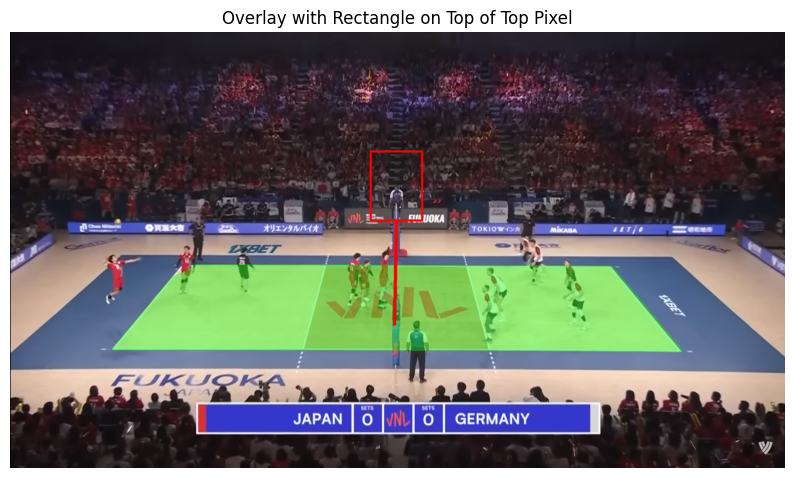

In [27]:
# Get the top pixel of the longest line
top_pixel = longest_line[0] if longest_line[0][1] < longest_line[1][1] else longest_line[1]
print(f"Top pixel coordinates: {top_pixel}")

# Define the size of the rectangle
rect_width = int(longest_length/2)  # Width of the rectangle
rect_height = int(longest_length/1.5)  # Height of the rectangle

# Calculate the top-left and bottom-right corners of the rectangle
final = overlay.copy()
top_left = (top_pixel[0] - rect_width // 2, top_pixel[1] - rect_height)
bottom_right = (top_pixel[0] + rect_width // 2, top_pixel[1])

# Draw the rectangle on the overlay
cv2.rectangle(final, top_left, bottom_right, (255, 0, 0), 5)  # Green rectangle with thickness 5

# Visualize the updated overlay
plt.figure(figsize=(10, 6))
plt.imshow(final)
plt.title('Overlay with Rectangle on Top of Top Pixel')
plt.axis('off')
plt.show()